In [2]:
import os
import mediapipe as mp 
import numpy as np
import cv2
import math
import pickle
import tensorflow as tf


## **1. Alphabet Landmarks**

---

In [2]:
list_of_metrics = {}

### Common Functions used:

In [3]:
def preprocess(data, labels):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split

    # STEP 1: Data Distribution Check
    print("Data Shape: ", data.shape, "||  Label Shape: ", labels.shape)
    unique, counts = np.unique(labels, return_counts=True)
    print("\nOriginal Label Distribution:\n", dict(zip(unique, counts)))

    # STEP 2: Convert labels to a Categorical Variable
    lab = tf.keras.utils.to_categorical(labels)

    # STEP 3: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(data, lab, test_size=0.2, random_state=42)

    unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
    print("\nTraining:\n", X_train.shape, y_train.shape, "\n") #, dict(zip(unique, counts)))

    unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
    print("Test:\n", X_test.shape, y_test.shape, "\n") #, dict(zip(unique, counts)))

    return X_train, X_test, y_train, y_test
        

In [4]:
def train_model(input_shape = (21,2), output_shape=24):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    model = Sequential([
        Flatten(input_shape=(input_shape[0],)),
        Dense(64,  activation='relu'),
        Dense(128, activation='relu'),
        Dense(512, activation='relu'),
        Dropout(rate=0.1),
        Dense(512, activation='relu'),
        Dropout(rate=0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_shape, activation='softmax'),
    ])

    # model.summary()

    callback_checkpoint = ModelCheckpoint(
        './checkpoints/', monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch',
    )
    callback_loss = EarlyStopping(monitor='loss', patience=4)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[callback_checkpoint, callback_loss])
    return model, history

In [5]:
def evaluate_model(history, X_test, y_test, model, title, actions):
  """
    Input: 
      history - Model history variable
      X_test - Test features
      y_test - Target test variables
      model - Keras Model 

    Output:
      Accuracy Plot (Training + Validation)
      Loss Plot (Training + Validation)
      Confusion matrix
      Accuracy
      Classification Report
  """  

  from sklearn.metrics import classification_report, confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  scores = model.evaluate((X_test),y_test, verbose=0)
  
  fig, axs = plt.subplots(1,3, figsize=(22,6))
  fig.tight_layout()

  axs[0].plot(history.history['accuracy'])
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Model - Accuracy (' + title +")")
  axs[0].legend(['Training'], loc='lower right')

  axs[1].plot(history.history['loss'])
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Model Loss')
  axs[1].set_title('Model - Loss (' + title +")")
  axs[1].legend(['Training'], loc='upper right')

  target_names=actions
  
  y_true=[]
  for element in y_test:
      y_true.append(np.argmax(element))

  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba,axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)    
  g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                  xticklabels=target_names, yticklabels=target_names)
  axs[2].set_title("Confusion Matrix")
  plt.show()


  print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
  print(classification_report(y_true, prediction, target_names=target_names))

  return {"metrics": classification_report(y_true, prediction, target_names=target_names, output_dict=True)}

In [6]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [7]:
def get_distance(a,b):
    from math import pow, sqrt
    return round(sqrt(pow(b[0]-a[0],2) + pow(b[1]-a[1],2)), 4)

### Loading Landmarks and Labels

In [8]:
LANDMARK_PATH = os.path.join('./data/Character_Data_Landmarks')

actions = [chr(i) for i in range(ord('A'), ord('Z')) if chr(i)!='T']

no_sequences =  25
sequence_length = 30

print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [9]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


### **a. Just (X,Y)**

In [10]:
missing = []
data = []
labels = []

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                landmarks = []
                for handslms in result:
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append(lmx)
                        landmarks.append(lmy)
                
                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 42) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 42) (14211, 24) 

Test:
 (3553, 42) (3553, 24) 



In [12]:
model_xy, history = train_model( (X_train.shape[1],0), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 3ms/step - loss: 3.0197 - accuracy: 0.2764
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 0.5409 - accuracy: 0.8083
Epoch 3/50
445/445 [==============================] - 2s 3ms/step - loss: 0.3553 - accuracy: 0.8790
Epoch 4/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2394 - accuracy: 0.9191
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2435 - accuracy: 0.9194
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2513 - accuracy: 0.9188
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1834 - accuracy: 0.9430
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1880 - accuracy: 0.9419
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2045 - accuracy: 0.9375
Epoch 10/50
445/445 [==============================] - 2s 3ms/step - loss: 0.1995 - accuracy: 0.9367

In [13]:
model_xy.save("./model_saves/only_coordinates")

INFO:tensorflow:Assets written to: ./model_saves/only_coordinates\assets


In [48]:
from tensorflow.keras.models import load_model

model_xy = load_model("./model_saves/only_coordinates")

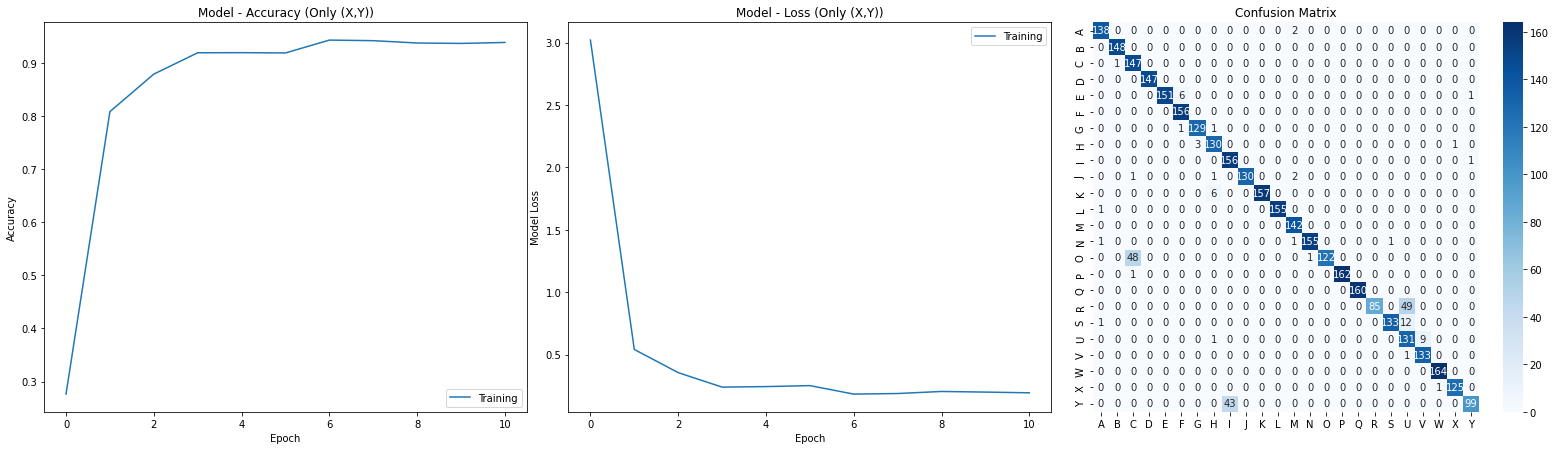


Accuracy: 94.43% 

              precision    recall  f1-score   support

           A       0.98      0.99      0.98       140
           B       0.99      1.00      1.00       148
           C       0.75      0.99      0.85       148
           D       1.00      1.00      1.00       147
           E       1.00      0.96      0.98       158
           F       0.96      1.00      0.98       156
           G       0.98      0.98      0.98       131
           H       0.94      0.97      0.95       134
           I       0.78      0.99      0.88       157
           J       1.00      0.97      0.98       134
           K       1.00      0.96      0.98       163
           L       1.00      0.99      1.00       156
           M       0.97      1.00      0.98       142
           N       0.99      0.98      0.99       158
           O       1.00      0.71      0.83       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [13]:
only_coordinates_results = evaluate_model(history, X_test, y_test, model_xy, "Only (X,Y)", actions)

In [15]:
# with open('data/results.pkl', 'rb') as f:
#     list_of_metrics = pickle.load(f)

# list_of_metrics['only_coordinates'] = only_coordinates_results

# with open('data/results.pkl', 'wb') as f:
#      pickle.dump(list_of_metrics, f)

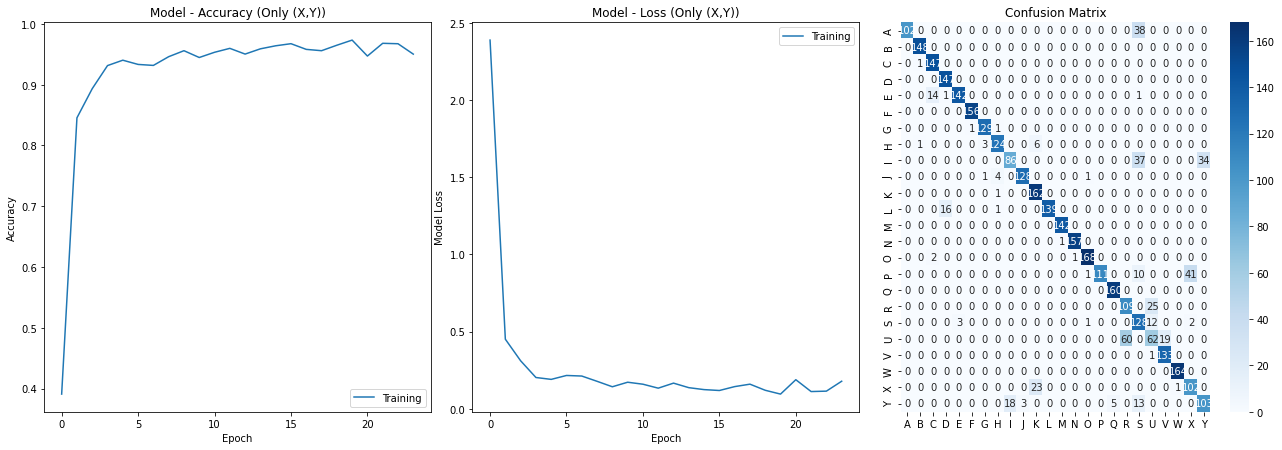


Accuracy: 88.63% 

              precision    recall  f1-score   support

           A       1.00      0.73      0.84       140
           B       0.99      1.00      0.99       148
           C       0.90      0.99      0.95       148
           D       0.90      1.00      0.95       147
           E       0.98      0.90      0.94       158
           F       0.99      1.00      1.00       156
           G       0.97      0.98      0.98       131
           H       0.95      0.93      0.94       134
           I       0.83      0.55      0.66       157
           J       0.98      0.96      0.97       134
           K       0.85      0.99      0.92       163
           L       1.00      0.89      0.94       156
           M       0.99      1.00      1.00       142
           N       0.99      0.99      0.99       158
           O       0.98      0.98      0.98       171
           P       1.00      0.68      0.81       163
           Q       0.97      1.00      0.98       160
       

In [25]:
only_coordinates_results = evaluate_model(history, X_test, y_test, model_xy, "Only (X,Y)", actions)

In [17]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

two_angles
only_coordinates


In [12]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model_xy, "./public")

### **b. Two Angles**

In [10]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    # print(angle_1, angle_2)
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append(lmx)
                        landmarks.append(lmy)
                    landmarks.append(angle_1)
                    landmarks.append(angle_2)
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [11]:
print(data.shape, labels.shape)

(17764, 44) (17764,)


In [12]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 44) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 44) (14211, 24) 

Test:
 (3553, 44) (3553, 24) 



In [13]:
model_two_angles, history = train_model( (X_train.shape[1], 0), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 3ms/step - loss: 3.5148 - accuracy: 0.0517
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 1.7216 - accuracy: 0.4552
Epoch 3/50
445/445 [==============================] - 1s 3ms/step - loss: 0.4763 - accuracy: 0.8294
Epoch 4/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3181 - accuracy: 0.8891
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2372 - accuracy: 0.9224
Epoch 6/50
445/445 [==============================] - 2s 3ms/step - loss: 0.2222 - accuracy: 0.9288
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1824 - accuracy: 0.9417
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1684 - accuracy: 0.9510
Epoch 9/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2335 - accuracy: 0.9338
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1504 - accuracy: 0.9556

In [13]:
model_two_angles.save('./model_saves/two_angles')

INFO:tensorflow:Assets written to: ./model_saves/two_angles\assets


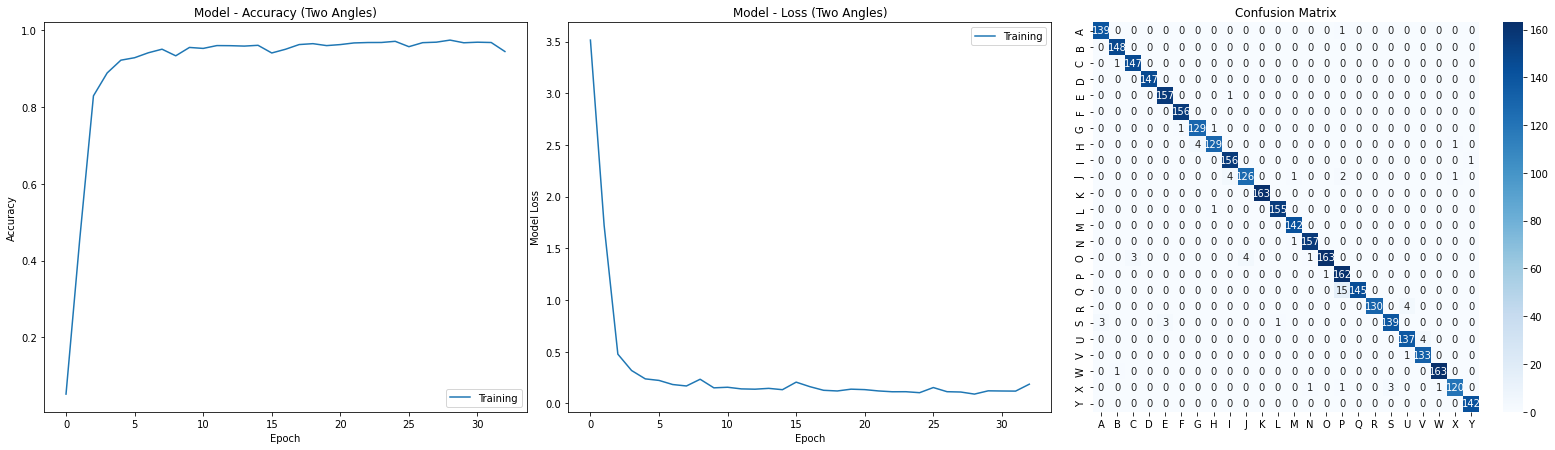


Accuracy: 98.09% 

              precision    recall  f1-score   support

           A       0.98      0.99      0.99       140
           B       0.99      1.00      0.99       148
           C       0.98      0.99      0.99       148
           D       1.00      1.00      1.00       147
           E       0.98      0.99      0.99       158
           F       0.99      1.00      1.00       156
           G       0.97      0.98      0.98       131
           H       0.98      0.96      0.97       134
           I       0.97      0.99      0.98       157
           J       0.97      0.94      0.95       134
           K       1.00      1.00      1.00       163
           L       0.99      0.99      0.99       156
           M       0.99      1.00      0.99       142
           N       0.99      0.99      0.99       158
           O       0.99      0.95      0.97       171
           P       0.90      0.99      0.94       163
           Q       1.00      0.91      0.95       160
       

In [14]:
two_angles_results = evaluate_model(history, X_test, y_test, model_two_angles, "Two Angles", actions)

In [17]:
list_of_metrics['two_angles'] = two_angles_results

In [19]:
with open('data/results.pkl','wb') as f:
    pickle.dump(list_of_metrics, f)

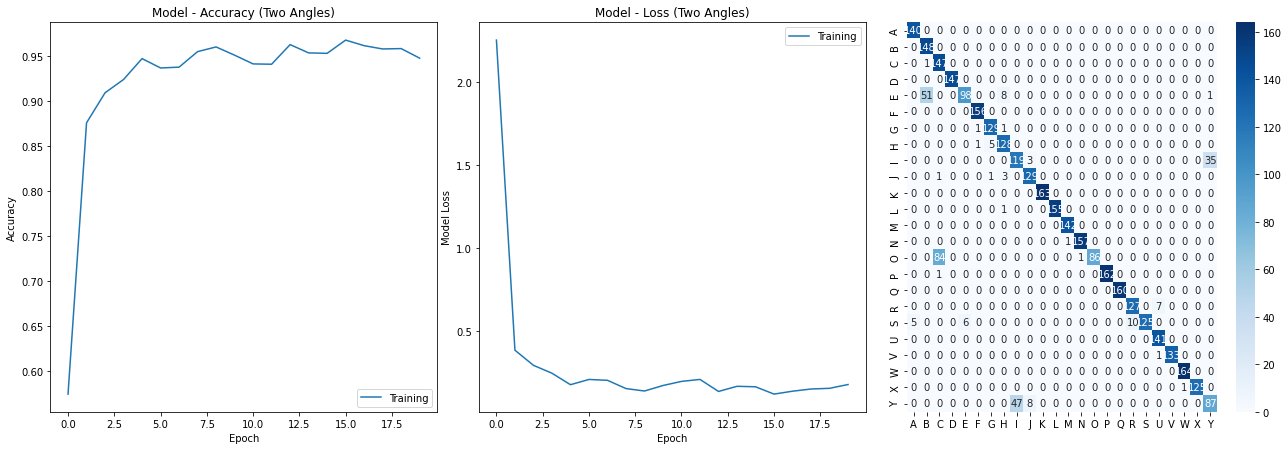


Accuracy: 91.98% 

              precision    recall  f1-score   support

           A       0.97      1.00      0.98       140
           B       0.74      1.00      0.85       148
           C       0.63      0.99      0.77       148
           D       1.00      1.00      1.00       147
           E       0.94      0.62      0.75       158
           F       0.99      1.00      0.99       156
           G       0.96      0.98      0.97       131
           H       0.91      0.96      0.93       134
           I       0.72      0.76      0.74       157
           J       0.92      0.96      0.94       134
           K       1.00      1.00      1.00       163
           L       1.00      0.99      1.00       156
           M       0.99      1.00      1.00       142
           N       0.99      0.99      0.99       158
           O       1.00      0.50      0.67       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [25]:
two_angles_results = evaluate_model(history, X_test, y_test, model_two_angles, "Two Angles", actions)

### **c. Distance + Angles**

In [15]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                    landmarks.append([angle_1, angle_2])
                    landmarks.append([distance_1, distance_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [16]:
print(data.shape, labels.shape)

(17764, 23, 2) (17764,)


In [17]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 23, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 23, 2) (14211, 24) 

Test:
 (3553, 23, 2) (3553, 24) 



In [18]:
model_angle_and_distance, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 3s 4ms/step - loss: 2.9921 - accuracy: 0.3418
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 0.5700 - accuracy: 0.8006
Epoch 3/50
445/445 [==============================] - 2s 4ms/step - loss: 0.3370 - accuracy: 0.8869
Epoch 4/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2506 - accuracy: 0.9157
Epoch 5/50
445/445 [==============================] - 2s 3ms/step - loss: 0.2423 - accuracy: 0.9217
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1960 - accuracy: 0.9402
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2434 - accuracy: 0.9227
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1798 - accuracy: 0.9500
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1749 - accuracy: 0.9481
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1349 - accuracy: 0.9633

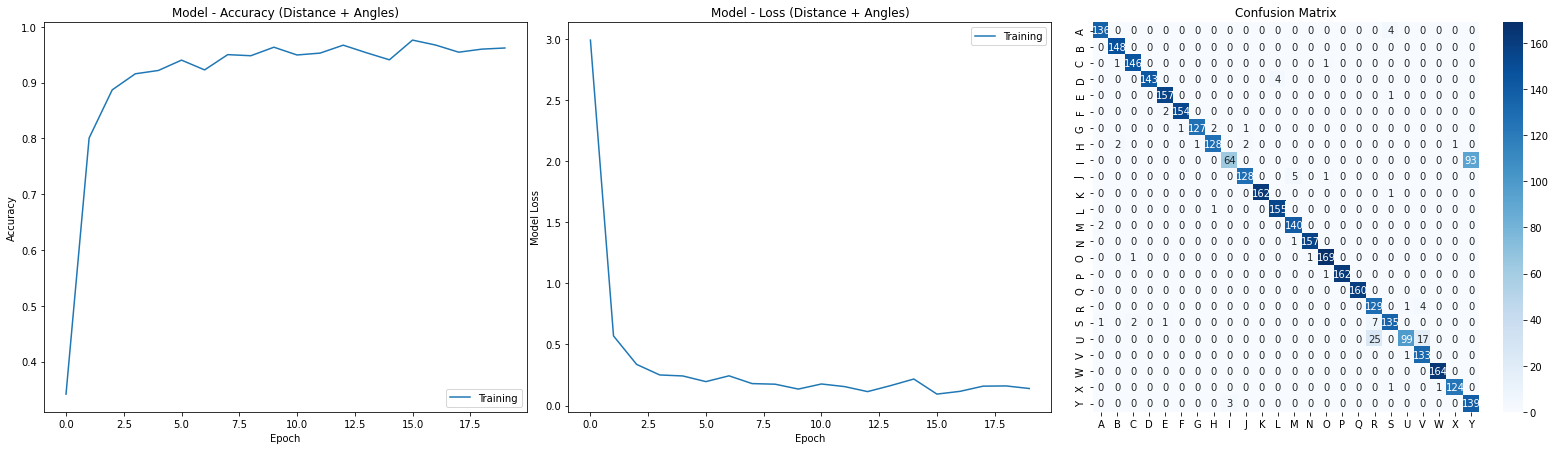


Accuracy: 94.54% 

              precision    recall  f1-score   support

           A       0.98      0.97      0.97       140
           B       0.98      1.00      0.99       148
           C       0.98      0.99      0.98       148
           D       1.00      0.97      0.99       147
           E       0.98      0.99      0.99       158
           F       0.99      0.99      0.99       156
           G       0.99      0.97      0.98       131
           H       0.98      0.96      0.97       134
           I       0.96      0.41      0.57       157
           J       0.98      0.96      0.97       134
           K       1.00      0.99      1.00       163
           L       0.97      0.99      0.98       156
           M       0.96      0.99      0.97       142
           N       0.99      0.99      0.99       158
           O       0.98      0.99      0.99       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [19]:
angle_and_distance_results = evaluate_model(history, X_test, y_test, model_angle_and_distance, "Distance + Angles", actions)

In [14]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

list_of_metrics['angle+distance'] = angle_and_distance_results

with open('data/results.pkl', 'wb') as f:
     pickle.dump(list_of_metrics, f)

### **B. Random Forest**

In [11]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    # angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    # angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    # distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    # distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append(lmx) 
                        landmarks.append(lmy)
                    # landmarks.append([angle_1, angle_2])
                    # landmarks.append([distance_1, distance_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [12]:
print(data.shape, labels.shape)

(17764, 42) (17764,)


In [13]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 42) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 42) (14211, 24) 

Test:
 (3553, 42) (3553, 24) 



In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train) 

RandomForestClassifier(random_state=42)

In [16]:
y_pred = clf.predict(X_test)

In [25]:
print(y_pred.shape, y_test.shape)
print(y_pred.argmax(axis=1).shape)
print(y_test.argmax(axis=1).shape)


(3553, 24) (3553, 24)
(3553,)
(3553,)


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(round(accuracy_score(y_test, y_pred),3))

0.993


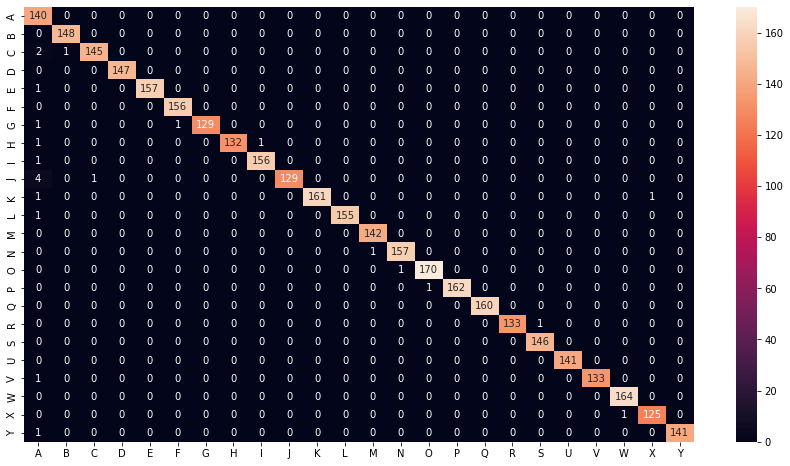

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15,8))
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax= sns.heatmap(cnf_matrix, annot=True,  fmt='g',
                  xticklabels=actions, yticklabels=actions)
plt.show()

In [30]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       140
           1       0.99      1.00      1.00       148
           2       0.99      0.98      0.99       148
           3       1.00      1.00      1.00       147
           4       1.00      0.99      1.00       158
           5       0.99      1.00      1.00       156
           6       1.00      0.98      0.99       131
           7       1.00      0.99      0.99       134
           8       0.99      0.99      0.99       157
           9       1.00      0.96      0.98       134
          10       1.00      0.99      0.99       163
          11       1.00      0.99      1.00       156
          12       0.99      1.00      1.00       142
          13       0.99      0.99      0.99       158
          14       0.99      0.99      0.99       171
          15       1.00      0.99      1.00       163
          16       1.00      1.00      1.00       160
          17       1.00    

<br>

---

## **Results**

In [24]:
print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [34]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

two_angles
only_coordinates
angle+distance


In [45]:
results = {}

for method in list_of_metrics.keys():

    alpha_results = {}
    metrics = list_of_metrics[method]['metrics']
    
    for key,value in metrics.items():
        if key in actions:
            alpha_results[key] = {'precision':round(value['precision'], 3), 'f1':round(value['f1-score'], 3), 'recall':round(value['recall'], 3)} 
        
        elif key=='accuracy':
            accuracy = value
        elif key=='weighted avg':
            results[method] = {"Accuracy": accuracy, "F1": round(value['f1-score'],3), "Sub-Scores": alpha_results}

for (key, value) in results.items(): 
    print(key, ":\n", "Accuracy: ", value["Accuracy"], "\n F1: ", value["F1"], "\n Sub-Scores: ")
    for k,v in value["Sub-Scores"].items():
            print("\t", k, ": ", v)
    print("\n\n")

two_angles :
 Accuracy:  0.9777652687869406 
 F1:  0.978 
 Sub-Scores: 
	 A :  {'precision': 0.985, 'f1': 0.948, 'recall': 0.914}
	 B :  {'precision': 0.987, 'f1': 0.993, 'recall': 1.0}
	 C :  {'precision': 0.993, 'f1': 0.993, 'recall': 0.993}
	 D :  {'precision': 0.967, 'f1': 0.983, 'recall': 1.0}
	 E :  {'precision': 0.993, 'f1': 0.977, 'recall': 0.962}
	 F :  {'precision': 0.987, 'f1': 0.994, 'recall': 1.0}
	 G :  {'precision': 0.985, 'f1': 0.985, 'recall': 0.985}
	 H :  {'precision': 0.992, 'f1': 0.969, 'recall': 0.948}
	 I :  {'precision': 0.924, 'f1': 0.96, 'recall': 1.0}
	 J :  {'precision': 0.985, 'f1': 0.977, 'recall': 0.97}
	 K :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 L :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 M :  {'precision': 0.973, 'f1': 0.986, 'recall': 1.0}
	 N :  {'precision': 0.994, 'f1': 0.99, 'recall': 0.987}
	 O :  {'precision': 0.988, 'f1': 0.988, 'recall': 0.988}
	 P :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 Q :  {'precision'